In [1]:
# Analysis for CT Pretrial Detainees
# (Springboard Capstone 1)
# 2019, Misty M. Giles

# Set up plotting  
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns

# Import standard packages
import numpy as np
import pandas as pd
import scipy.stats as stats
from scipy.stats import uniform

# Import misc tools
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline

# Import verification tools
from sklearn.model_selection import cross_val_score

# Import preprocessing tools
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import Normalizer
from sklearn.preprocessing import StandardScaler
from sklearn.utils import resample

# Import models
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import RandomizedSearchCV
from sklearn.multiclass import OneVsRestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier

# Select the file created in CT_csv (unit 5 data wrangling assignment)
file = 'detainees_classed_offenses.csv'

C:\Users\Misty\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [2]:
# Read in the file
df = pd.read_csv(file, parse_dates=['download_date', 'latest_admission_date'])

# Change from previous notebooks to drop the single case of 'UM' at the 
# beginning -- inclusion prevents use of 'stratify'.)
df['offense_class'] = [offense[-2:] if offense.endswith(('AM','BM','CM','DM',' M', 
                       'AF','BF','CF','DF',' F')) else np.nan for offense in df.offense]

# Days that CT says a detainee has been in the system.  This doesn't account for
# some detainees.  There are 730 days in the dataset, and the state says that entrance 
# dates over a year before could be original entrance date but are definitely not to be
# trusted.  The days column will be capped at 1,095 (730 + 365).  
df.days = [int(time[:-23]) for time in df.days]
df.days = [time if time <= 1095 else 1095 for time in df.days]

#df = df.loc[df.days<1095]

# Check that everything worked.  There should be 0 null values.
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28808 entries, 0 to 28807
Data columns (total 13 columns):
download_date            28808 non-null datetime64[ns]
identifier               28808 non-null object
latest_admission_date    28808 non-null datetime64[ns]
race                     28808 non-null object
gender                   28808 non-null object
age                      28808 non-null int64
bond_amount              28808 non-null int64
offense                  28808 non-null object
facility                 28808 non-null object
detainer                 28808 non-null object
offense_class            28807 non-null object
days                     28808 non-null int64
counts                   28808 non-null int64
dtypes: datetime64[ns](2), int64(4), object(7)
memory usage: 2.9+ MB


In [3]:
# Only working with the 94% under 80k.
#df = df.loc[df.bond_amount<=80000]
#print(df.info())

# Separate out the two datasets, misdemeanor (primary) and felony.
misdemeanor_df = df.loc[df['offense_class'].str.endswith('M',na=False)].reset_index(
    drop=True).rename(index=str, columns={'offense_class_ M':'offense_class_M'})

# Change race, gender, facility, and detainer to category type and verify.
misdemeanor_df.race = misdemeanor_df.race.astype('category')
misdemeanor_df.gender = misdemeanor_df.gender.astype('category')
misdemeanor_df.facility = misdemeanor_df.facility.astype('category')
misdemeanor_df.detainer = misdemeanor_df.detainer.astype('category')
misdemeanor_df.offense_class = misdemeanor_df.offense_class.astype('category')

# Divide the misdemeanor data into pre-enactment and post.
mis_pre_df = misdemeanor_df.loc[misdemeanor_df.download_date < '2017-07-01']
mis_post_df = misdemeanor_df.loc[misdemeanor_df.download_date >= '2017-07-01']
mis_post_df = mis_post_df.loc[mis_post_df.download_date < '2018-07-01']
mis_outofbounds_df = misdemeanor_df.loc[misdemeanor_df.download_date >= '2018-07-01']
mis_df = pd.concat([mis_pre_df, mis_post_df])

# Check that everything worked.  There should be 0 null values.
misdemeanor_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 9663 entries, 0 to 9662
Data columns (total 13 columns):
download_date            9663 non-null datetime64[ns]
identifier               9663 non-null object
latest_admission_date    9663 non-null datetime64[ns]
race                     9663 non-null category
gender                   9663 non-null category
age                      9663 non-null int64
bond_amount              9663 non-null int64
offense                  9663 non-null object
facility                 9663 non-null category
detainer                 9663 non-null category
offense_class            9663 non-null category
days                     9663 non-null int64
counts                   9663 non-null int64
dtypes: category(5), datetime64[ns](2), int64(4), object(2)
memory usage: 1.0+ MB


In [4]:
# Utility function to report best scores
def report(results, n_top=3):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print('')
            print('Model with rank:', i)
            print('Mean validation score: %0.2f (+/- %0.2f)' %
                  (results['mean_test_score'][candidate],
                  results['std_test_score'][candidate]))
            print('Parameters: {0}'.format(results['params'][candidate]))

### Gender categorization:
1. Define data and target from the pre-enactment dataframe
2. Split, preprocess, and fit
3. Test the accuracy on pre-enactment test data
4. See what happens with the post-enactment data

One problem that has to be addressed is the imbalance of male/female samples.  Here's the original percentage:

In [5]:
print('Original male/female split: %0.4f' % (len(mis_pre_df.loc[mis_pre_df.gender=='M'])/len(mis_pre_df.gender)))

Original male/female split: 0.8272


And here's how logistic regression first handles the data.  It guesses "M" and gets it right frequently enough that it calls it quits.

In [6]:
# Define data and target
X = mis_pre_df[['bond_amount','days','age','offense_class','race']]
X = pd.get_dummies(X,columns=['offense_class','race'],drop_first=True)
y = mis_pre_df.gender.ravel()

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=.3,stratify=y,random_state=3)

# Classifier
clf = LogisticRegression()

clf.fit(X_train,y_train)

# Print the accuracy
scores = cross_val_score(clf, X_test, y_test, cv=5) 
print('Accuracy, gender (test): %0.4f (+/- %0.2f)' % (scores.mean(), scores.std() * 2))

Accuracy, gender (test): 0.8269 (+/- 0.00)


Time to upsample the "F" samples.  Data to be used on logistic regression, KNN, and random forest models for gender models.

In [7]:
# Define data and target
to_rebalance_df = mis_pre_df[['bond_amount','days','age','gender','offense_class','race']]
to_rebalance_df = pd.get_dummies(to_rebalance_df,columns=['offense_class','race'],drop_first=True)

rebalance_F = to_rebalance_df.loc[to_rebalance_df.gender=='F']
rebalance_M = to_rebalance_df.loc[to_rebalance_df.gender=='M']

samples = len(rebalance_M)

F_upsampled = resample(rebalance_F, replace=True, n_samples=samples)

balanced_df = pd.concat([F_upsampled,rebalance_M])

print('New counts:')
print(balanced_df.gender.value_counts())

X = balanced_df.drop('gender',axis=1)
y = balanced_df.gender.ravel()

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=.3,stratify=y,random_state=3)

New counts:
M    3216
F    3216
Name: gender, dtype: int64


First pass at balanced logistic regression.  

In [8]:
# Rescale the data
scaler = MinMaxScaler()

# Classifier
lr = LogisticRegression(random_state=3)

pl = Pipeline([
        ('scaler', scaler),
        ('clf', lr)
    ])

pl = pl.fit(X_train,y_train)

# Print the accuracy
scores = cross_val_score(pl, X_test, y_test, cv=5) 
lr_to_beat = round(scores.mean(),2)
print('Accuracy, gender (test): %0.2f (+/- %0.2f)' % (scores.mean(), scores.std() * 2))

Accuracy, gender (test): 0.59 (+/- 0.05)


Finally, some progress.  The model is no longer guessing.  Now, for some hyperparameters.

In [9]:
# Create regularization penalty space
penalty = ['l1', 'l2']

# Create regularization hyperparameter distribution using uniform distribution
C = uniform(loc=0, scale=100)
#C = [0.0001, 0.001, 0.01, 0.1, 1, 5, 10, 50, 100, 1000]

# Create hyperparameter options
hyperparameters = dict(C=C, penalty=penalty)

# Run randomized search with train scores turned on to stop pink deprecation warnings
n_iter_search = 20
random_search = RandomizedSearchCV(lr, hyperparameters, n_iter=n_iter_search, cv=5, return_train_score=False)

random_search.fit(X_train, y_train)
print('RandomizedSearchCV for', n_iter_search, 'candidates parameter settings:')
report(random_search.cv_results_)

best_lr = random_search.best_estimator_
best_lr.fit(X_train,y_train)

RandomizedSearchCV for 20 candidates parameter settings:

Model with rank: 1
Mean validation score: 0.62 (+/- 0.01)
Parameters: {'C': 27.17240408642654, 'penalty': 'l1'}

Model with rank: 1
Mean validation score: 0.62 (+/- 0.01)
Parameters: {'C': 12.409114411214617, 'penalty': 'l1'}

Model with rank: 3
Mean validation score: 0.62 (+/- 0.01)
Parameters: {'C': 33.47860995440296, 'penalty': 'l1'}

Model with rank: 3
Mean validation score: 0.62 (+/- 0.01)
Parameters: {'C': 66.1797336847196, 'penalty': 'l1'}

Model with rank: 3
Mean validation score: 0.62 (+/- 0.01)
Parameters: {'C': 54.778491244527075, 'penalty': 'l1'}

Model with rank: 3
Mean validation score: 0.62 (+/- 0.01)
Parameters: {'C': 63.3227918699802, 'penalty': 'l1'}

Model with rank: 3
Mean validation score: 0.62 (+/- 0.01)
Parameters: {'C': 49.020326137368464, 'penalty': 'l1'}

Model with rank: 3
Mean validation score: 0.62 (+/- 0.01)
Parameters: {'C': 60.695828581140745, 'penalty': 'l1'}


LogisticRegression(C=27.17240408642654, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l1', random_state=3,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

Tuned logistic regression below.  Hyperparameters don't improve the model.

In [10]:
pl = Pipeline([
        ('scaler', scaler),
        ('clf', best_lr)
    ])

pl.fit(X_train,y_train)

Pipeline(memory=None,
     steps=[('scaler', MinMaxScaler(copy=True, feature_range=(0, 1))), ('clf', LogisticRegression(C=27.17240408642654, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l1', random_state=3,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False))])

In [11]:
# Print the accuracy of the tuned LR
scores = cross_val_score(pl, X_test, y_test, cv=5) 
print('Accuracy, gender (test): %0.2f (+/- %0.2f)' % (scores.mean(), scores.std() * 2))

Accuracy, gender (test): 0.59 (+/- 0.03)


Trying out KNN for k=1...39 and plotting the cross-validated accuracy.

Best: [1, 2, 3, 4, 5, 6, 7, 9, 13]


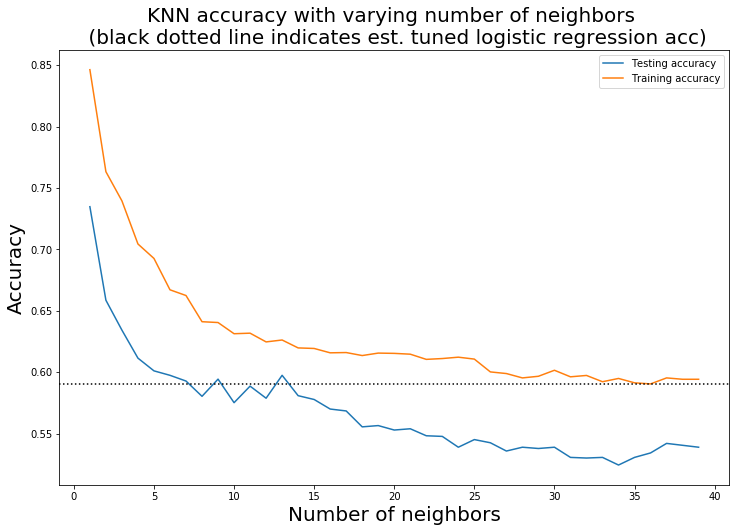

In [12]:
# Set up variables for testing
neighbors = np.arange(1,40,1) 
train_accuracy = np.zeros(len(neighbors))
test_accuracy = np.zeros(len(neighbors))
best_acc = []
best_neighbor = []

for i,k in enumerate(neighbors):
    
    # Rescale the data
    scaler = Normalizer()
    # Call classifier with neighbor choices
    clf = KNeighborsClassifier(n_neighbors=k)
    # Set up the pipeline
    pl = Pipeline([
        ('scaler', scaler),
        ('clf', clf)
    ])

    #Fit the model
    pl.fit(X_train,y_train)

    #Compute accuracy on the training set
    train_accuracy[i] = cross_val_score(pl, X_train, y_train, cv=5).mean()

    #Compute accuracy on the test set
    test_accuracy[i] = cross_val_score(pl, X_test, y_test, cv=5).mean()
    
    if (test_accuracy[i]>lr_to_beat):
        best_neighbor.append(k)
        best_acc.append(test_accuracy[i])
        
print('Best:', best_neighbor)
    
_ = plt.figure(figsize=(12,8))
_ = plt.title('KNN accuracy with varying number of neighbors \n (black dotted line indicates est. tuned logistic regression acc)', fontsize=20)
_ = plt.plot(neighbors, test_accuracy, label='Testing accuracy')
_ = plt.plot(neighbors, train_accuracy, label='Training accuracy')
_ = plt.legend()
_ = plt.xlabel('Number of neighbors', fontsize=20)
_ = plt.ylabel('Accuracy', fontsize=20)
_ = plt.axhline(lr_to_beat, color='black', linestyle=':', label='LogReg accuracy')

In [13]:
# Build the model with the best neighbors from test above and print testing cv acc for each
for k in best_neighbor:
    # Rescale the data
    scaler = Normalizer()

    # Classifier
    clf = KNeighborsClassifier(n_neighbors=k)

    pl = Pipeline([
        ('scaler', scaler),
        ('clf', clf)
    ])

    pl.fit(X_train,y_train)

    # Print the accuracy
    scores = cross_val_score(pl, X_test, y_test, cv=5) 
    print('Accuracy, gender (test) for',k,'neighbors: %0.2f (+/- %0.2f)' % (scores.mean(), scores.std() * 2))

Accuracy, gender (test) for 1 neighbors: 0.73 (+/- 0.05)
Accuracy, gender (test) for 2 neighbors: 0.66 (+/- 0.05)
Accuracy, gender (test) for 3 neighbors: 0.63 (+/- 0.04)
Accuracy, gender (test) for 4 neighbors: 0.61 (+/- 0.04)
Accuracy, gender (test) for 5 neighbors: 0.60 (+/- 0.04)
Accuracy, gender (test) for 6 neighbors: 0.60 (+/- 0.02)
Accuracy, gender (test) for 7 neighbors: 0.59 (+/- 0.03)
Accuracy, gender (test) for 9 neighbors: 0.59 (+/- 0.03)
Accuracy, gender (test) for 13 neighbors: 0.60 (+/- 0.03)


KNN is interesting here.  I wanted to at least try it because I felt there was potential, but the drop is too steep.  The accuracy drops in line with or below logistic regression quickly.  K=[1,2,3] were the only ks with accuracy consistently over 65% in any testing, and ks that small would be very sensitive to noise, etc.  

Moving on to random forests.

Accuracy, gender (test): 0.75 (+/- 0.02)


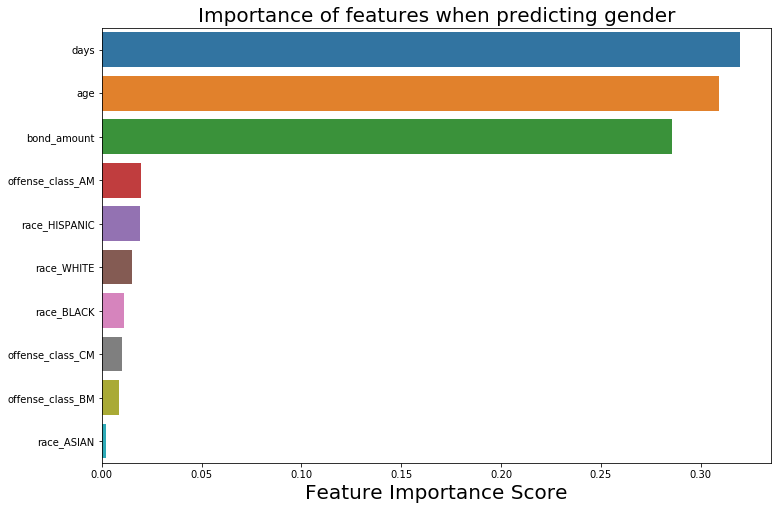

In [14]:
# Classifier
rf = RandomForestClassifier(n_estimators=100,random_state=3)

rf.fit(X_train,y_train)

scores = cross_val_score(rf, X_test, y_test, cv=5) 
print('Accuracy, gender (test): %0.2f (+/- %0.2f)' % (scores.mean(), scores.std() * 2))

feature_imp = pd.Series(rf.feature_importances_,index=X.columns).sort_values(ascending=False)
_ = plt.figure(figsize=(12,8))
_ = sns.barplot(x=feature_imp, y=feature_imp.index)
_ = plt.xlabel('Feature Importance Score', fontsize=20)
_ = plt.title('Importance of features when predicting gender', fontsize=20)

As somewhat expected, the cross_val_score of the random forest is higher than the logistic regression, increasing from lower 60s to about 75% out of the box.  Random forest will be tuned in further steps.

Here's the code to search for the best hyperparameters.  The search claims that a tuned random forest will reach nearly 90% accuracy, by far the highest potential of the tested estimators.

In [15]:
# Parameters to test in randomizedsearchcv
param_dist = {'n_estimators': [300, 500, 1000],
              'max_features': [.3, .5],
              'min_samples_split': [3, 4, 5],
              'bootstrap': [True],
              'criterion': ['gini', 'entropy'],
              'oob_score': [True]}

# Run randomized search
n_iter_search = 20
random_search = RandomizedSearchCV(rf, param_distributions=param_dist,
                                   n_iter=n_iter_search, cv=5, return_train_score=False, n_jobs=-1)

random_search.fit(X_train, y_train)
print('Ranked parameter settings, cv with training data:')
report(random_search.cv_results_)

best_rf = random_search.best_estimator_
best_rf.fit(X_train,y_train)

Ranked parameter settings, cv with training data:

Model with rank: 1
Mean validation score: 0.88 (+/- 0.01)
Parameters: {'oob_score': True, 'n_estimators': 300, 'min_samples_split': 3, 'max_features': 0.3, 'criterion': 'gini', 'bootstrap': True}

Model with rank: 2
Mean validation score: 0.87 (+/- 0.02)
Parameters: {'oob_score': True, 'n_estimators': 500, 'min_samples_split': 3, 'max_features': 0.5, 'criterion': 'entropy', 'bootstrap': True}

Model with rank: 3
Mean validation score: 0.87 (+/- 0.01)
Parameters: {'oob_score': True, 'n_estimators': 300, 'min_samples_split': 3, 'max_features': 0.5, 'criterion': 'gini', 'bootstrap': True}

Model with rank: 3
Mean validation score: 0.87 (+/- 0.02)
Parameters: {'oob_score': True, 'n_estimators': 500, 'min_samples_split': 3, 'max_features': 0.3, 'criterion': 'gini', 'bootstrap': True}

Model with rank: 3
Mean validation score: 0.87 (+/- 0.02)
Parameters: {'oob_score': True, 'n_estimators': 1000, 'min_samples_split': 3, 'max_features': 0.5, '

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features=0.3, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=3,
            min_weight_fraction_leaf=0.0, n_estimators=300, n_jobs=1,
            oob_score=True, random_state=3, verbose=0, warm_start=False)

The OOB score from the best rf classifier shows the expected improvement on the unused training data.

In [16]:
best_rf.oob_score_

0.9069302532207908

But when you apply it to the test set, the accuracy drops.  It is consistently very near (or exactly) the orginal rf accuracy, and I can't find an explanation for this behaviour.

In [17]:
test_scores = cross_val_score(best_rf, X_test, y_test, cv=5)
print('Accuracy, gender (test): %0.2f (+/- %0.2f)' % (test_scores.mean(), test_scores.std() * 2))
test_scores

Accuracy, gender (test): 0.75 (+/- 0.01)


array([0.75388601, 0.75906736, 0.75647668, 0.75129534, 0.74352332])

And here's a cross tabulation of the test set predictions.  About 13-15% of females are misclassified compared to 3-5% of males.

# NOTE TO LINDY:
## This doesn't even make sense.  75% accuracy on the test set, but 85% of the females and 95% of the males are correctly classified?  This is what's driving me insane about that accuracy in box 16.

gender        F      M
predicts              
F         0.856  0.144
M         0.035  0.965


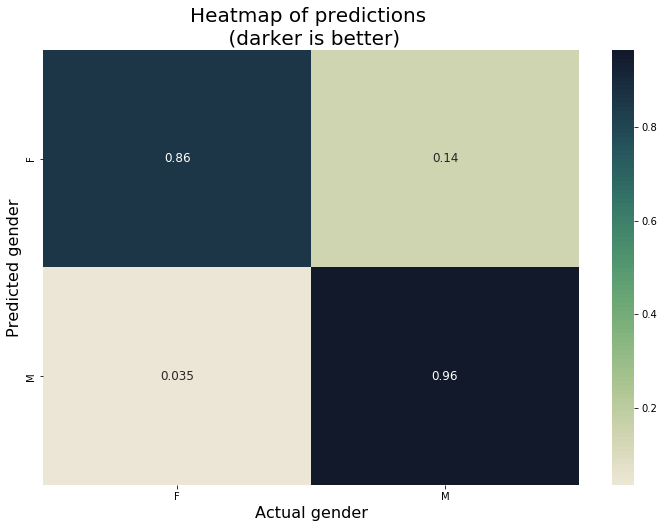

In [18]:
# Calculate the cluster labels
labels = best_rf.predict(X_test)

# Create a DataFrame with labels and species as columns
ct_df = pd.DataFrame({'predicts': labels, 'gender': y_test})

# Create crosstab
ct = pd.crosstab(ct_df.predicts, ct_df.gender).apply(lambda x: (round(x/x.sum(),3)), axis=1)

# Display ct
print(ct)

# And display as a heatmap as an alternate way of understanding
_ = plt.figure(figsize=(12, 8))
_ = sns.heatmap(ct,annot=True,annot_kws={'size':12},cmap=sns.cubehelix_palette(100,start=360,rot=-.6,light=.9,dark=.1))
_ = plt.xlabel('Actual gender',fontsize=16)
_ = plt.ylabel('Predicted gender',fontsize=16) 
_ = plt.title('Heatmap of predictions \n (darker is better)',fontsize=20)

Now that the model is created, how does it do on the post-enactment period?

In [19]:
# Define data and target
to_rebalance_df_post = mis_post_df[['bond_amount','days','age','gender','offense_class','race']]
to_rebalance_df_post = pd.get_dummies(to_rebalance_df_post,columns=['offense_class','race'],drop_first=True)

rebalance_F_post = to_rebalance_df_post.loc[to_rebalance_df_post.gender=='F']
rebalance_M_post = to_rebalance_df_post.loc[to_rebalance_df_post.gender=='M']

samples_post = len(rebalance_M_post)

F_upsampled_post = resample(rebalance_F_post, replace=True, n_samples=samples_post)

balanced_df_post = pd.concat([F_upsampled_post,rebalance_M_post])

A = balanced_df_post.drop('gender',axis=1)
b = balanced_df_post.gender.ravel()

scores = cross_val_score(best_rf, A, b, cv=5) 
print('Accuracy, gender (test): %0.2f (+/- %0.2f)' % (scores.mean(), scores.std() * 2))

Accuracy, gender (test): 0.90 (+/- 0.03)


### It is possible to create a predictor that is 100% correct for gender if you include the facility.  CT only has one facility for housing both pretrial and sentenced women.  (Source: https://portal.ct.gov/DOC/Facility/York-CI)

This is not balanced or processed in any way.  It's just for representation.

Accuracy, gender (test): 1.00 (+/- 0.00)


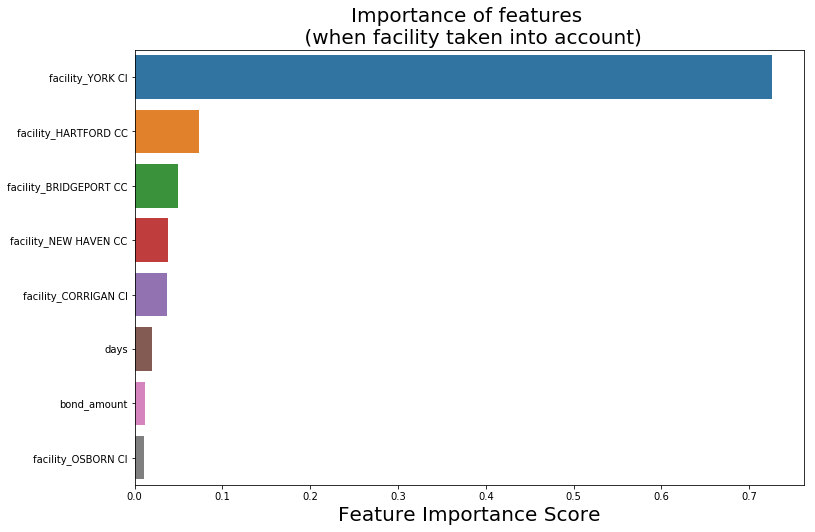

In [20]:
# Define data and target
X = mis_pre_df[['bond_amount','days','age','offense_class','race','facility']]
X = pd.get_dummies(X,columns=['offense_class','race','facility'],drop_first=True)
y = mis_pre_df.gender.ravel()

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=.3,stratify=y,random_state=3)

# Classifier
clf = RandomForestClassifier(n_estimators=100,random_state=3)

clf.fit(X_train,y_train)

scores = cross_val_score(clf, X_test, y_test, cv=5) 
print('Accuracy, gender (test): %0.2f (+/- %0.2f)' % (scores.mean(), scores.std() * 2))

feature_imp = pd.Series(clf.feature_importances_,index=X.columns).sort_values(ascending=False)
# Restrict the features available on the y-axis so you can read them
_ = plt.figure(figsize=(12,8))
_ = sns.barplot(x=feature_imp[:8], y=feature_imp.index[:8])
_ = plt.xlabel('Feature Importance Score',fontsize=20)
_ = plt.title('Importance of features \n (when facility taken into account)',fontsize=20)